In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

In [2]:
%load_ext autoreload
%autoreload

### Loading Bank Note Dataset

In [3]:
train = pd.read_csv('../datasets/bank-note/train.csv', header=None).to_numpy()
test = pd.read_csv('../datasets/bank-note/test.csv', header=None).to_numpy()

In [145]:
### last column is label (-1,1)

x_train = train[:,:-1]
y_train = train[:,-1]
y_train = np.where(y_train == 0, -1,1)

x_test = test[:,:-1]
y_test = test[:,-1]
y_test= np.where(y_test == 0, -1,1)

# add column of ones to wrap in b
x_train = np.concatenate((x_train, np.ones((x_train.shape[0],1))), axis=1)
x_test = np.concatenate((x_test, np.ones((x_test.shape[0],1))), axis=1)

shuffle = np.random.choice(len(x_train), len(x_train), replace=False)
x_train = x_train[shuffle]
y_train = y_train[shuffle]

### Problem 2 SVM Primal

In [149]:
### utilities
calc_avg_error = lambda preds,labels: (preds != labels).mean()
predict = lambda x,w: np.sign(x @ w)

def calc_avg_j(w_0,w,C,N,X,labels):
    preds = X @ w
    margins = labels*preds
    max_terms = np.max((np.zeros((len(margins))), 1-margins))
    j = 0.5*(w_0 @ w_0.T) + (C * N*max_terms)
    return j.mean()
    
print('Beginning SVM primal domain, stochastic sub-gradient descent')

Beginning SVM primal domain, stochastic sub-gradient descent


In [150]:
update_lr1 = lambda lr, t, a: lr / (1 + (lr/a)*t)
update_lr2 = lambda lr, t: lr / (1 + t)

### PROBLEM 2A, LR Schedule 1

In [151]:
lr = 0.001
a = 0.5 ## need to tune this probs
num_epochs = 5000
Cs = [100/873, 500 / 873, 700 / 873]
N = len(x_train)
np.random.seed(42)
train_losses = np.zeros((len(Cs), num_epochs))
test_losses = np.zeros((len(Cs), num_epochs))

for c_i, C in enumerate(Cs):
    # initialize w
    w_0 = np.zeros((x_train.shape[1]-1,))
    w = np.concatenate((w_0,[0]))
    for epoch in range(num_epochs):
        ## shuffle at each epoch
        shuffle = np.random.choice(len(x_train), len(x_train), replace=False)
        x_train = x_train[shuffle]
        y_train = y_train[shuffle]
        
        for i in range(x_train.shape[0]):
            ## shuffle at each epoch
            label = y_train[i]
            pred = x_train[i] @ w
            margin = label*pred
            max_term = np.max((0.0, 1-margin))
            if max_term: ### if margin is smaller than 1
                grad = np.concatenate((w_0,[0])) - (C*N*label*x_train[i])
                w = w - lr * grad
            else: ### if margin greater or equal to 1
                w_0 = w_0 - (lr * w_0)
    
        train_losses[c_i,epoch] = calc_avg_j(w_0,w,C,N,x_train,y_train)
        test_losses[c_i, epoch] = calc_avg_j(w_0,w,C,N,x_test,y_test)
        lr = update_lr1(lr, epoch, a)
    print(f'with {C=} and learning rate schedule 1:')
    print(f'final train loss = {train_losses[c_i,-1]}')
    print(f'final test loss = {test_losses[c_i,-1]}')
    train_acc = (predict(x_train,w) == y_train).mean()
    test_acc = (predict(x_test,w) == y_test).mean()
    print(f'{train_acc=}, {test_acc=}')
    print(f'{w=}')


with C=0.1145475372279496 and learning rate schedule 1:
final train loss = 362.37574396216894
final test loss = 424.66709529353284
train_acc=0.9908256880733946, test_acc=0.992
w=array([-8.50099582, -4.43401111, -5.68458722, -0.79338309,  7.2484419 ])
with C=0.572737686139748 and learning rate schedule 1:
final train loss = 901.1229733549652
final test loss = 901.1049924790761
train_acc=0.9919724770642202, test_acc=0.992
w=array([-1.12366863, -0.78752587, -0.88482591, -0.11464667,  1.43884356])
with C=0.8018327605956472 and learning rate schedule 1:
final train loss = 1234.9060764789072
final test loss = 1234.8824950087192
train_acc=0.9919724770642202, test_acc=0.992
w=array([-1.05180177, -0.74524569, -0.83057191, -0.10861972,  1.33966403])


Text(0.5, 0, 'epoch')

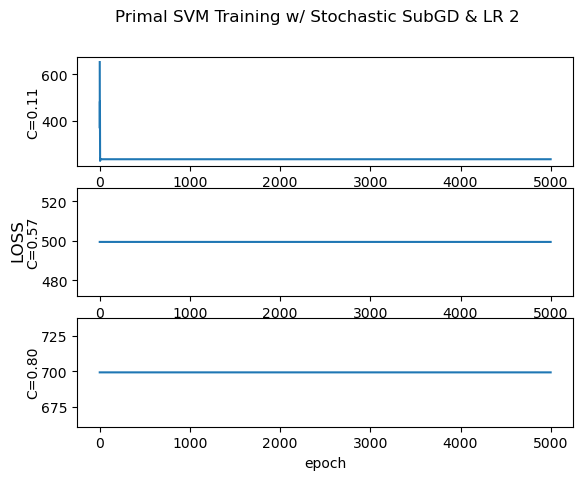

In [98]:
fig, ax = plt.subplots(len(Cs))
for i in range(len(Cs)):
    C = Cs[i]
    ax[i].plot(train_losses[i])
    ax[i].set_ylabel(f'{C=:.2f}',labelpad=0.4)
fig.suptitle('Primal SVM Training w/ Stochastic SubGD & LR 2')
fig.supylabel('LOSS')
ax[-1].set_xlabel('epoch')

### PROBLEM 2B, LR Schedule 2

In [154]:
lr = 0.001
a = 0.5 ## need to tune this probs
num_epochs = 5000
Cs = [100/873, 500 / 873, 700 / 873]
N = len(x_train)
np.random.seed(42)
train_losses = np.zeros((len(Cs), num_epochs))
test_losses = np.zeros((len(Cs), num_epochs))

for c_i, C in enumerate(Cs):
    # initialize w
    w_0 = np.zeros((x_train.shape[1]-1,))
    w = np.concatenate((w_0,[0]))
    for epoch in range(num_epochs):
        ## shuffle at each epoch
        shuffle = np.random.choice(len(x_train), len(x_train), replace=False)
        x_train = x_train[shuffle]
        y_train = y_train[shuffle]
        
        for i in range(x_train.shape[0]):
            ## shuffle at each epoch
            label = y_train[i]
            pred = x_train[i] @ w
            margin = label*pred
            max_term = np.max((0.0, 1-margin))
            if max_term: ### if margin is smaller than 1
                grad = np.concatenate((w_0,[0])) - (C*N*label*x_train[i])
                w = w - lr * grad
            else: ### if margin greater or equal to 1
                w_0 = w_0 - (lr * w_0)
    
        train_losses[c_i,epoch] = calc_avg_j(w_0,w,C,N,x_train,y_train)
        test_losses[c_i, epoch] = calc_avg_j(w_0,w,C,N,x_test,y_test)
        lr = update_lr2(lr, epoch)
    print(f'with {C=} and learning rate schedule 2:')
    print(f'final train loss = {train_losses[c_i,-1]}')
    print(f'final test loss = {test_losses[c_i,-1]}')
    train_acc = (predict(x_train,w) == y_train).mean()
    test_acc = (predict(x_test,w) == y_test).mean()
    print(f'{train_acc=}, {test_acc=}')
    print(f'{w=}')

with C=0.1145475372279496 and learning rate schedule 2:
final train loss = 260.7385603679266
final test loss = 260.72392616141406
train_acc=0.9896788990825688, test_acc=0.99
w=array([-4.33918389, -2.83398892, -3.30102213, -0.81671859,  4.01040092])
with C=0.572737686139748 and learning rate schedule 2:
final train loss = 499.42726231386024
final test loss = 499.42726231386024
train_acc=0.0, test_acc=0.0
w=array([0., 0., 0., 0., 0.])
with C=0.8018327605956472 and learning rate schedule 2:
final train loss = 699.1981672394044
final test loss = 699.1981672394044
train_acc=0.0, test_acc=0.0
w=array([0., 0., 0., 0., 0.])


Text(0.5, 0, 'epoch')

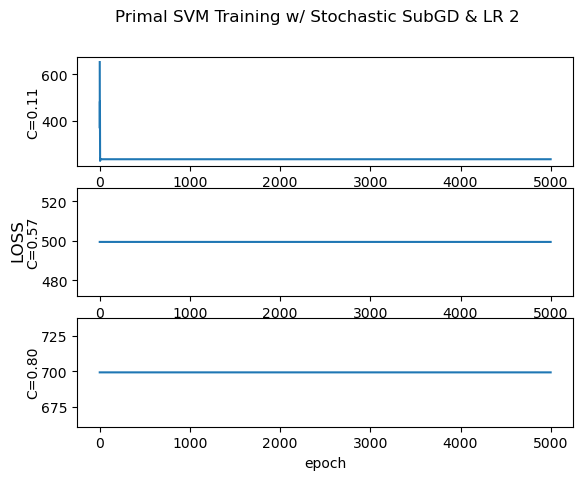

In [97]:
fig, ax = plt.subplots(len(Cs))
for i in range(len(Cs)):
    C = Cs[i]
    ax[i].plot(train_losses[i])
    ax[i].set_ylabel(f'{C=:.2f}',labelpad=0.4)
fig.suptitle('Primal SVM Training w/ Stochastic SubGD & LR 2')
fig.supylabel('LOSS')
ax[-1].set_xlabel('epoch')

### Homework problem 5

In [18]:
print('Beginning HW written problem 1')

data = np.array([[0.5,-1,0.3,1], [-1,-2,-2,-1], [1.5,0.2,-2.5,1]])
x = data[:,:3]
y = data[:,-1]
lrs = [0.01, 0.005, 0.0025]
### wrap in b
x = np.concatenate((x, np.ones((x.shape[0],1))), axis=1)
w_0 = np.zeros((x.shape[1]-1,))
w = np.zeros((x.shape[1],))
N = len(x)
C = 1
### 3 steps w/ given learning rate
for i,lr in enumerate(lrs):
    label = y[i]
     # np.sign(x @ w)
    pred = x[i] @ w
    margin = label*pred
    max_term = np.max((0, 1-margin)) 
    if max_term: ### if margin is smaller than 1
        grad = np.concatenate((w_0,[0])) - (C*N*label*x[i])
        print(f'subgradient for step {i} is {grad}')
        w = w - lr * grad
    else: ### if margin greater or equal to 1
        print(f'subgradient for step {i} is {np.concatenate((w_0,[0]))=}')
        w_0 = w_0 - (lr * w_0)


subgradient for step 0 is [-1.5  3.  -0.9 -3. ]
subgradient for step 1 is [-3. -6. -6.  3.]
subgradient for step 2 is [-4.5 -0.6  7.5 -3. ]


### 3A) SVM Dual Domain

In [178]:
from scipy.optimize import minimize 
from typing import Callable
import pickle

def gaussian_kernel(X1,X2,gamma=0.1): 
    norm_diff_squared = ((X1 - X2)**2).sum(axis=-1)
    return np.exp(-1 * (norm_diff_squared / gamma))
    
def identity_kernel(X1,X2):
    return (X1 * X2).sum(axis=-1)

def objective(a,C,X,y,kernel: Callable):
    indexes = np.arange(len(X))
    i_s,j_s = np.meshgrid(indexes, indexes)
    term1 = y[i_s] * y[j_s] * a[i_s] * a[j_s] \
            * kernel(X[i_s],X[j_s])
    term1 = 0.5 * term1.sum()
    term2 = a.sum()
    return term1 - term2

y = y_train

### Identity Kernel/ No Kernel w/ different Cs

In [280]:
# print('starting SVM duel with various C values and no kernel')

### comment out scipy minimize and load from pkl files

# Cs = [100/873, 500 / 873, 700 / 873]
# optims = []
# for C in Cs:
#     y = y_train
#     a = np.zeros((len(x_train))) 
#     constraints = ({'type': 'ineq','fun': lambda a: a },
#                {'type': 'ineq', 'args': (C,),'fun': lambda a,C: C-a},
#                {'type': 'eq', 'args': (y,),'fun': lambda a,y: (a*y).sum()}
#               )
#     optim = minimize(objective, 
#                     x0 = a, 
#                     args = ((C,x_train,y_train,identity_kernel,)),
#                     constraints=constraints)
#     optims.append(optim)
#     with open(f'C_{C:.2f}.pkl','wb') as f:
#         pickle.dump(optim, f, protocol=pickle.HIGHEST_PROTOCOL)



starting SVM duel with various C values and no kernel


In [206]:
from glob import glob
optims = []
for optim_file in glob('./C_*'):
    print(optim_file)
    with open(optim_file, 'rb') as f:
        optims.append(pickle.load(f))
    

./C_0.11.pkl
./C_0.57.pkl
./C_0.80.pkl


In [207]:
optims[0]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.99728555521732
       x: [-1.435e-11 -1.162e-11 ... -8.154e-12  7.617e-12]
     nit: 17
     jac: [ 7.068e-01  2.791e+00 ...  3.021e+00  1.407e+00]
    nfev: 14850
    njev: 17

In [226]:
for i,optim in enumerate(optims): 
    a = optim['x']
    w = np.sum((x_train.T * (a * y_train)),axis=1)
    b = [np.mean(y_train - (x_train @ w))] 
    train_preds = np.sign((x_train @ w) + b)
    test_preds = np.sign((x_test @ w) + b)
    train_acc = (train_preds == y_train).mean()
    test_acc = (test_preds == y_test).mean()
    print(f'[w;b] = {np.concatenate((w,b))}')
    print(f'dual SVM w no kernel and C={Cs[i]:2f},\n {train_acc=}, \n {test_acc=}')

[w;b] = [-9.42926198e-01 -6.51491781e-01 -7.33721938e-01 -4.10218921e-02
  4.21446305e-16  2.51728412e+00]
dual SVM w no kernel and C=0.114548,
 train_acc=0.9736238532110092, 
 test_acc=0.97
[w;b] = [-9.42926198e-01 -6.51491781e-01 -7.33721938e-01 -4.10218921e-02
  4.21446305e-16  2.51728412e+00]
dual SVM w no kernel and C=0.572738,
 train_acc=0.9736238532110092, 
 test_acc=0.97
[w;b] = [-9.42926198e-01 -6.51491781e-01 -7.33721938e-01 -4.10218921e-02
  4.21446305e-16  2.51728412e+00]
dual SVM w no kernel and C=0.801833,
 train_acc=0.9736238532110092, 
 test_acc=0.97


### 3B) Gaussian Kernel w/ different C settings and gamma settings 

In [ ]:
def gaussian_kernel(X1,X2,gamma=0.1): 
    norm_diff_squared = ((X1 - X2)**2).sum(axis=-1)
    return np.exp(-1 * (norm_diff_squared / gamma))
def objective(a,C,X,y,kernel: Callable):
    indexes = np.arange(len(X))
    i_s,j_s = np.meshgrid(indexes, indexes)
    term1 = y[i_s] * y[j_s] * a[i_s] * a[j_s] \
            * kernel(X[i_s],X[j_s])
    term1 = 0.5 * term1.sum()
    term2 = a.sum()
    return term1 - term2

In [251]:
Cs = [100/873, 500 / 873, 700 / 873]
gammas = [0.1, 0.5, 1, 5, 100]

### comment out calling scipy package and load from pkl files

# optims = []
# for gamma in gammas:
#     for C in Cs:
#         y = y_train
#         kernel = partial(gaussian_kernel, gamma=gamma)
#         a = np.zeros((len(x_train))) 
#         constraints = ({'type': 'ineq','fun': lambda a: a },
#                {'type': 'ineq', 'args': (C,),'fun': lambda a,C: C-a},
#                {'type': 'eq', 'args': (y,),'fun': lambda a,y: (a*y).sum()}
#               )
#         optim = minimize(objective, 
#                         x0 = a, 
#                         args = ((C,x_train,y_train,kernel,)),
#                         constraints=constraints)
#         optims.append(optim)
#         with open(f'gaussk_{gamma}_{C:.2f}.pkl','wb') as f:
#             pickle.dump(optim, f, protocol=pickle.HIGHEST_PROTOCOL)
            

KeyboardInterrupt: 

In [275]:
optims_gauss = []
files = glob('./gaussk_*')
files.sort()

for optim_file in files:
    print(optim_file)
    with open(optim_file, 'rb') as f:
        optims_gauss.append(pickle.load(f))


./gaussk_0.1_0.11.pkl
./gaussk_0.1_0.57.pkl
./gaussk_0.1_0.80.pkl
./gaussk_0.5_0.11.pkl
./gaussk_0.5_0.57.pkl
./gaussk_0.5_0.80.pkl
./gaussk_1_0.11.pkl
./gaussk_1_0.57.pkl
./gaussk_1_0.80.pkl
./gaussk_5_0.11.pkl
./gaussk_5_0.57.pkl
./gaussk_5_0.80.pkl


In [253]:
def kernel_svm_pred(x_train, y_train, x_test, kernel, a):
    preds = np.zeros((len(x_test)))
    b = np.mean(y_train - (x_train @ w))
    for i in range(len(x_test)):
        K = np.array([kernel(x_test[i],ex) for ex in x_train])
        pred = np.sign(((a * y_train * K).sum() + b))
        preds[i] = pred
    return preds

In [254]:
rep_Cs = Cs*4
for i,optim in enumerate(optims_gauss): 
    file = files[i]
    gamma = float(file.split('_')[1])
    C = rep_Cs[i]
    a = optim['x']
    kernel = partial(gaussian_kernel,gamma=gamma)
    train_preds = kernel_svm_pred(x_train,y_train,x_train,kernel,a)
    test_preds = kernel_svm_pred(x_train,y_train,x_test,kernel,a)
    train_acc = (train_preds == y_train).mean()
    test_acc = (test_preds == y_test).mean()
    print(f'[w;b] = {np.concatenate((w,b))}')
    print(f'dual SVM w gauss kernel, {gamma=} and C={C:2f},\n {train_acc=}, \n {test_acc=}')


[w;b] = [-1.76133937e+02 -2.39851730e+02  4.79041739e+01 -6.83309077e-01
 -1.13797860e-15  4.83704124e+02]
dual SVM w gauss kernel, gamma=0.1 and C=0.114548,
 train_acc=0.4461009174311927, 
 test_acc=0.442
[w;b] = [-1.76133937e+02 -2.39851730e+02  4.79041739e+01 -6.83309077e-01
 -1.13797860e-15  4.83704124e+02]
dual SVM w gauss kernel, gamma=0.1 and C=0.572738,
 train_acc=0.4461009174311927, 
 test_acc=0.442
[w;b] = [-1.76133937e+02 -2.39851730e+02  4.79041739e+01 -6.83309077e-01
 -1.13797860e-15  4.83704124e+02]
dual SVM w gauss kernel, gamma=0.1 and C=0.801833,
 train_acc=0.4461009174311927, 
 test_acc=0.442
[w;b] = [-1.76133937e+02 -2.39851730e+02  4.79041739e+01 -6.83309077e-01
 -1.13797860e-15  4.83704124e+02]
dual SVM w gauss kernel, gamma=0.5 and C=0.114548,
 train_acc=0.4461009174311927, 
 test_acc=0.442
[w;b] = [-1.76133937e+02 -2.39851730e+02  4.79041739e+01 -6.83309077e-01
 -1.13797860e-15  4.83704124e+02]
dual SVM w gauss kernel, gamma=0.5 and C=0.572738,
 train_acc=0.44610

### 3C) how many support vectors are the same for different values of gamma? 

In [276]:
rep_Cs = Cs*4
for i,optim in enumerate(optims_gauss): 
    file = files[i]
    C = rep_Cs[i]
    gamma = float(file.split('_')[1])
    num_support_vecs = (optim['x'] > 0).sum()
    print(f'{num_support_vecs=} for {C=} and {gamma=}')

num_support_vecs=870 for C=0.1145475372279496 and gamma=0.1
num_support_vecs=872 for C=0.572737686139748 and gamma=0.1
num_support_vecs=870 for C=0.8018327605956472 and gamma=0.1
num_support_vecs=837 for C=0.1145475372279496 and gamma=0.5
num_support_vecs=837 for C=0.572737686139748 and gamma=0.5
num_support_vecs=825 for C=0.8018327605956472 and gamma=0.5
num_support_vecs=818 for C=0.1145475372279496 and gamma=1.0
num_support_vecs=811 for C=0.572737686139748 and gamma=1.0
num_support_vecs=778 for C=0.8018327605956472 and gamma=1.0
num_support_vecs=790 for C=0.1145475372279496 and gamma=5.0
num_support_vecs=479 for C=0.572737686139748 and gamma=5.0
num_support_vecs=449 for C=0.8018327605956472 and gamma=5.0


In [279]:
### w/ all C = 100 / 873
import itertools
a = np.arange(4)
pairs = list(itertools.product(a, a))
files_index = np.array([0,3,6,9]) ## optimizers where C = 100/872 for diff gammas
optims = np.array(optims_gauss)[files_index]
print('3c. begin comparing support vectors for gauss kernel SVM models w/ different gammas')
for pair in pairs: 
    print(f'comparing gamma={gammas[pair[0]]} and gamma={gammas[pair[1]]}', end=', ')
    support_vecs_1 = optims[pair[0]]['x'] > 0
    print(support_vecs_1.sum(), support_vecs_2.sum(), end=' ')
    support_vecs_2 = optims[pair[1]]['x'] > 0
    print(f'num matching support vectors: {np.logical_and(support_vecs_1,support_vecs_2).sum()}')

3c. begin comparing support vectors for gauss kernel SVM models w/ different gammas
comparing gamma=0.1 and gamma=0.1, 870 790 num matching support vectors: 870
comparing gamma=0.1 and gamma=0.5, 870 870 num matching support vectors: 836
comparing gamma=0.1 and gamma=1, 870 837 num matching support vectors: 817
comparing gamma=0.1 and gamma=5, 870 818 num matching support vectors: 788
comparing gamma=0.5 and gamma=0.1, 837 790 num matching support vectors: 836
comparing gamma=0.5 and gamma=0.5, 837 870 num matching support vectors: 837
comparing gamma=0.5 and gamma=1, 837 837 num matching support vectors: 810
comparing gamma=0.5 and gamma=5, 837 818 num matching support vectors: 761
comparing gamma=1 and gamma=0.1, 818 790 num matching support vectors: 817
comparing gamma=1 and gamma=0.5, 818 870 num matching support vectors: 810
comparing gamma=1 and gamma=1, 818 837 num matching support vectors: 818
comparing gamma=1 and gamma=5, 818 818 num matching support vectors: 746
comparing ga

### Bonus Kernel Perceptron Alg

In [138]:
from functools import partial

In [140]:
def kernel_perceptron_pred(x_train, y_train, x_test, kernel):
    preds = np.zeros((len(test)))
    for i in range(len(test)):
        K = np.array([kernel(x_test[i],ex) for ex in x_train])
        pred = np.sign((c * y_train * K).sum())
        preds[i] = pred
    return preds

In [144]:
for gamma in gammas:
    kernel = partial(gaussian_kernel, gamma=gamma)
    print(f'starting gaussian kernel perceptron training w/ {gamma=}')
    c = np.zeros((len(x_train)))
    num_epochs = 10
    train_accs = np.zeros((num_epochs))
    test_accs = np.zeros((num_epochs))
    
    for i in range(num_epochs):
        preds = np.zeros((len(x_train)))
        for j in range(len(x_train)):
            K = np.array([kernel(x_train[j],ex) for ex in x_train])
            pred = np.sign((c[j] * y_train[j] * K).sum())
            if pred != y_train[i]:
                c[j] = c[j] + 1
            preds[j] = pred
        train_accs[i] = (preds == y_train).mean()
        print(f'epoch {i} train_acc = {train_accs[i]}')
    
    test_preds = kernel_perceptron_pred(x_train, y_train, x_test, kernel)
    print(f'test acc: {(test_preds == y_test).mean()}')

starting gaussian kernel perceptron training w/ gamma=0.1
epoch 0 train_acc = 0.0
epoch 1 train_acc = 1.0
epoch 2 train_acc = 1.0
epoch 3 train_acc = 1.0
epoch 4 train_acc = 1.0
epoch 5 train_acc = 1.0
epoch 6 train_acc = 1.0
epoch 7 train_acc = 1.0
epoch 8 train_acc = 1.0
epoch 9 train_acc = 1.0
test acc: 0.998
starting gaussian kernel perceptron training w/ gamma=0.5
epoch 0 train_acc = 0.0
epoch 1 train_acc = 1.0
epoch 2 train_acc = 1.0
epoch 3 train_acc = 1.0
epoch 4 train_acc = 1.0
epoch 5 train_acc = 1.0
epoch 6 train_acc = 1.0
epoch 7 train_acc = 1.0
epoch 8 train_acc = 1.0
epoch 9 train_acc = 1.0
test acc: 0.998
starting gaussian kernel perceptron training w/ gamma=1
epoch 0 train_acc = 0.0
epoch 1 train_acc = 1.0
epoch 2 train_acc = 1.0
epoch 3 train_acc = 1.0
epoch 4 train_acc = 1.0
epoch 5 train_acc = 1.0
epoch 6 train_acc = 1.0
epoch 7 train_acc = 1.0
epoch 8 train_acc = 1.0
epoch 9 train_acc = 1.0
test acc: 0.998
starting gaussian kernel perceptron training w/ gamma=5
epoc